# Parameter Estimation of RIG Roll Experiments

## Setup and descriptions

* Without ACM model
* Turn **off** wind tunnel
* Only 1DoF for RIG roll movement
* Free in any angle and observe
* Consider RIG roll angle and its derivative as States (in radians)
$$X = \begin{pmatrix} \phi_{rig} \\ \dot{\phi}_{rig} \end{pmatrix}$$
* Observe RIG roll angle and its derivative as Outputs (in degrees)
$$Z = \begin{pmatrix} \phi_{rig} \\ \dot{\phi}_{rig} \end{pmatrix}$$
* Use output error method based on most-likehood(ML) to estimate
$$ \theta = \begin{pmatrix} F_{c} \\ f  \end{pmatrix} $$

## Startup computation engines

In [2]:
%run matt_startup
%run -i matt_utils

button_qtconsole()

#import other needed modules in all used engines
#with dview.sync_imports():
#   import os

importing numpy on engine(s)
importing scipy on engine(s)
importing matplotlib on engine(s)
importing scipy.integrate on engine(s)
importing scipy.interpolate on engine(s)
importing math on engine(s)
importing time on engine(s)
importing itertools on engine(s)
importing random on engine(s)


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Data preparation

### Load raw data

In [34]:
filename = 'FIWT_Exp014_20150601105647.dat.npz'

def loadData():
    # Read and parse raw data
    global exp_data
    exp_data = np.load(filename)

    # Select colums
    global T_rig, phi_rig
    T_rig = exp_data['data44'][:,0]
    phi_rig = exp_data['data44'][:,2]

loadData()

In [35]:
text_loadData()

### Check time sequence and inputs/outputs

Click 'Check data' button to show the raw data. 

Click on curves to select time point and push into queue; click 'T/s' text to pop up last point in the queue; and click 'Output' text to print time sequence table.

In [36]:
def checkInputOutputData():

    #check inputs/outputs
    fig, ax = plt.subplots(2,1,True)
    ax[1].plot(T_rig,phi_rig, 'b', picker=2)
    ax[1].set_ylabel('$\phi \/ / \/ ^o/s$')
    ax[1].set_xlabel('$T \/ / \/ s$', picker=True)
    ax[0].set_title('Output', picker=True)
    

    fig.canvas.mpl_connect('pick_event', onPickTime)
    fig.show()
    display(fig)

button_CheckData()

### Input $\delta_T$ and focused time ranges

For each section,
* Select time range and shift it to start from zero;
* Resample Time, Inputs, Outputs in unique $\delta_T$;
* Smooth Input/Observe data if flag bit0 is set;
* Take derivatives of observe data if flag bit1 is set.

In [37]:

# Pick up focused time ranges
time_marks = [[341.47, 350, "free drop 1"],
              [369.83, 377, "free drop 2"],
              [392.38, 400, "free drop 3"],
              [413.57, 421, "free drop 4"],
              [439.80, 450, "free drop 5"],
              [463.46, 474, "free drop 6"],
              [488.48, 498, "free drop 7"],
              [509.40, 520, "free drop 8"],
              [531.80, 543, "free drop 9"],
              [557.84, 569, "free drop 10"],
              [587.60, 599, "free drop 11"],
              [615.00, 627, "free drop 12"]
             ]


# Decide DT,U,Z and their processing method
DT=0.01
process_set = {
            'U':[],
            'Z':[(T_rig, phi_rig,3),],
            'cutoff_freq': 10 #Hz
           }

U_names = []
Y_names = Z_names = ['$\phi_{a,rig} \, / \, ^o$',
                    '$\dot{\phi}_{a,rig} \, / \, ^o/s$',]

display_data_prepare()

<IPython.core.display.Math object>

Idx,Start(s),Spam(s),Description
0,341.47,8.53,free drop 1
1,369.83,7.17,free drop 2
2,392.38,7.62,free drop 3
3,413.57,7.43,free drop 4
4,439.80,10.20,free drop 5
5,463.46,10.54,free drop 6
6,488.48,9.52,free drop 7
7,509.40,10.60,free drop 8
8,531.80,11.20,free drop 9
9,557.84,11.16,free drop 10


$U$


$Z$
"$\phi_{a,rig} \, / \, ^o$"
"$\dot{\phi}_{a,rig} \, / \, ^o/s$"


## Resample and filter data in sections

In [38]:
resample(True);

## Define dynamic model to be estimated

$$\left\{\begin{matrix}
\ddot{\phi}_{rig} = \frac{M_{x,rig}}{I_{xx,rig}} \\
M_{x,rig} = M_{x,f} + M_{x,cg} \\
M_{x,f} = -F_c \, sign(\dot{\phi}_{rig}) - f\dot{\phi}_{rig} \\
M_{x,cg} = -m_T g  l_{zT} \sin \left ( \phi - \phi_0 \right ) \\
\end{matrix}\right.$$



In [39]:
%%px --local
#update common const parameters in all engines

#problem size
Nx = 2
Nu = 0
Ny = 2
Npar = 6

#reference
S_c = 0.1254   #S_c(m2) 
b_c = 0.7      #b_c(m)
g = 9.81       #g(m/s2)
l_z_T = 0.0416 #l_z_T(m)


#other parameters
v_th = 0.5/57.3  #v_th(rad/s)
v_th2 = 0.5/57.3  #v_th(rad/s)


def x0(Z,T,U,params):
    return Z[0,:]/57.3

def xdot(X,t,U,params):
    F_c     = params[0]
    f       = params[1]
    Ixx     = params[2]
    m_T     = params[3]
    kBrk    = params[4]
    phi0    = params[5]

    phi     = X[0]
    phi_dot = X[1]
        
    moments = -(m_T*l_z_T)*g*math.sin(phi-phi0)

    abs_phi_dot = abs(phi_dot)
    F = f*phi_dot
    if abs_phi_dot > v_th+v_th2:
        F += math.copysign(F_c, phi_dot)
    elif abs_phi_dot > v_th:
        F += math.copysign(F_c*(kBrk-(kBrk-1)*(abs_phi_dot-v_th)/v_th2), phi_dot)
    else:
        F += phi_dot/v_th*(F_c*kBrk)
    moments -= F
    
    phi_dot2 = moments/Ixx
    return [phi_dot, phi_dot2]

def obs(X,T,U,params):
    return X*57.3



In [40]:
display(HTML('<b>Constant Parameters</b>'))
table = ListTable()
table.append(['Name','Value','unit'])
table.append(['$S_c$',S_c,'$m^2$'])
table.append(['$b_c$',b_c,'$m$'])
table.append(['$g$',g,'$m/s^2$'])
table.append(['$l_{zT}$',l_z_T,'$m$'])
display(table)


Name,Value,unit
$S_c$,0.1254,$m^2$
$b_c$,0.7,$m$
$g$,9.81,$m/s^2$
$l_{zT}$,0.0416,$m$


# Initial guess

* Input default values and ranges for parameters
* Select sections for trainning
* Adjust parameters based on simulation results
* Decide start values of parameters for optimization

In [41]:
#initial guess
param0 = [
    0.05,    #F_c(N*m)
    0.03,     #f(N*m/(rad/s))
    0.2146,    #Ixx(kg*m2) 0.2146/1.06
    9.5588,     #m_T(kg)
    1.01,         #kBrk
       0,      #phi0(rad)
]

param_name = ['$F_c$','$f$', '$I_{xx,rig}$', '$m_T$','$k_{Brk}$','$phi_0$']
param_unit = ['$Nm$',r'$\frac{Nm}{rad/s}$', '$kg\,m^2$', 'kg','1', 'rad']

NparID = Npar
opt_idx = range(Npar)
opt_param0 = [param0[i] for i in opt_idx]
par_del = [0.3*1e-3,  0.3*1e-3,   0.2*1e-3,  0.01, 0.001, 0.0174]
bounds =  [(1e-6,0.15),(1e-6,0.1), (1e-6,0.5), (9,10),(1,1.5),(-0.1,0.1)]
display_default_params()

#select sections for training
section_idx = range(8)
display_data_for_train()

#push parameters to engines
push_opt_param()


Idx,Description,$x_0$,opt,$\delta_{par}$,min,max,unit
0,$F_c$,0.05,*,0.0003,1e-06,0.15,$Nm$
1,$f$,0.03,*,0.0003,1e-06,0.1,$\frac{Nm}{rad/s}$
2,"$I_{xx,rig}$",0.2146,*,0.0002,1e-06,0.5,"$kg\,m^2$"
3,$m_T$,9.5588,*,0.01,9,10,kg
4,$k_{Brk}$,1.01,*,0.001,1,1.5,1
5,$phi_0$,0,*,0.0174,-0.1,0.1,rad


Idx,Start(s),Spam(s),Description
0,341.47,8.53,free drop 1
1,369.83,7.17,free drop 2
2,392.38,7.62,free drop 3
3,413.57,7.43,free drop 4
4,439.80,10.20,free drop 5
5,463.46,10.54,free drop 6
6,488.48,9.52,free drop 7
7,509.40,10.60,free drop 8


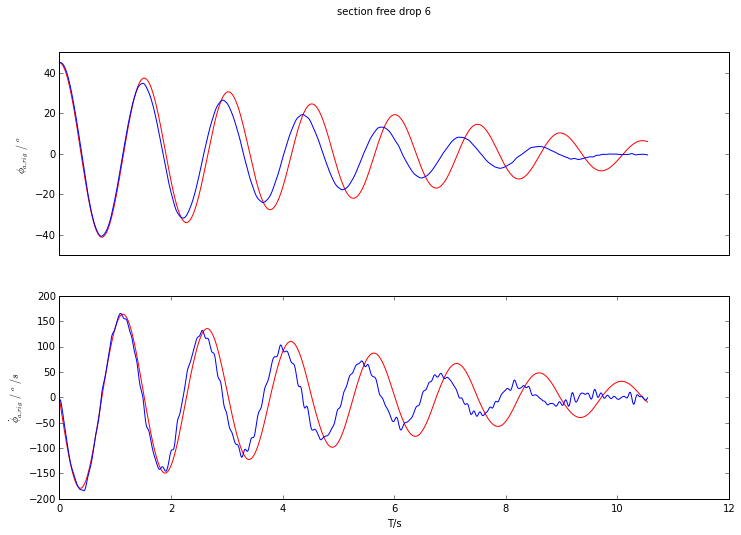

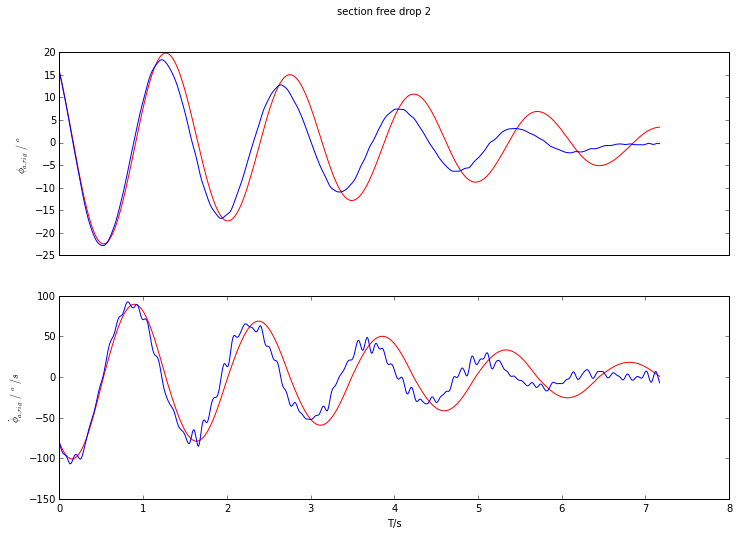

In [42]:
# select 2 section from training data
idx = random.sample(section_idx, 2)

interact_guess();

# Optimize using ML

In [43]:
display_preopt_params()

if False:
    InfoMat = None
    method = 'trust-ncg'
    def hessian(opt_params, index):
        global InfoMat
        return InfoMat
    dview['enable_infomat']=True
    options={'gtol':1}
    opt_bounds = None
else:
    method = 'L-BFGS-B'
    hessian = None
    dview['enable_infomat']=False
    options={'ftol':1e-4,'maxfun':200}
    opt_bounds = bounds

cnt = 0
tmp_rslt = None
T0 = time.time()
print('#cnt,     Time,      |R|')

%time res =  sp.optimize.minimize(fun=costfunc, x0=opt_param0, \
        args=(opt_idx,), method=method, jac=True, hess=hessian, \
        bounds=opt_bounds, options=options)


Idx,Description,$x_0$,opt,$\delta_{par}$,min,max,unit
0,$F_c$,0.05,*,0.0003,1e-06,0.15,$Nm$
1,$f$,0.03,*,0.0003,1e-06,0.1,$\frac{Nm}{rad/s}$
2,"$I_{xx,rig}$",0.2146,*,0.0002,1e-06,0.5,"$kg\,m^2$"
3,$m_T$,9.5588,*,0.01,9,10,kg
4,$k_{Brk}$,1.01,*,0.001,1,1.5,1
5,$phi_0$,0.0,*,0.0174,-0.1,0.1,rad


#cnt,     Time,      |R|
0001,    0.243,    67498.9
0002,    0.348,   980566.1
0003,    0.580,    54649.0
0004,    0.727,  1018183.6
0005,    0.994,    51711.2
0006,    1.264,    48871.4
0007,    1.446,   422832.6
0008,    1.675,    47081.7
0009,    1.895,    45342.1
0010,    2.097,    16339.3
0011,    2.348,      224.3
0012,    2.555,     1973.9
0013,    2.760,      182.1
0014,    2.869,   959999.6
0015,    3.092,      170.6
0016,    3.306,      119.9
0017,    3.512,       77.3
0018,    3.721,       56.6
0019,    3.934,       42.5
0020,    4.152,       34.6
0021,    4.356,      108.1
0022,    4.575,       28.5
0023,    4.803,       22.8
0024,    5.070,       24.5
0025,    5.283,       23.2
0026,    5.509,       22.8
0027,    5.713,       22.8
0028,    5.936,       22.8
0029,    6.149,       22.8
0030,    6.355,       22.8
0031,    6.552,       22.8
0032,    6.759,       22.8
0033,    6.960,       22.8
0034,    7.179,       22.8
0035,    7.383,       22.8
0036,    7.598,       22.8
003

## Show and test results

Idx,Description,$x$
0,$F_c$,0.0602058378029
1,$f$,0.0408385758964
2,"$I_{xx,rig}$",0.199219876253
3,$m_T$,9.58516187758
4,$k_{Brk}$,1.00940106854
5,$phi_0$,-0.00859890684427


Idx,Start(s),Spam(s),Description
0,341.47,8.53,free drop 1
1,369.83,7.17,free drop 2
2,392.38,7.62,free drop 3
3,413.57,7.43,free drop 4
4,439.80,10.20,free drop 5
5,463.46,10.54,free drop 6
6,488.48,9.52,free drop 7
7,509.40,10.60,free drop 8
8,531.80,11.20,free drop 9
9,557.84,11.16,free drop 10


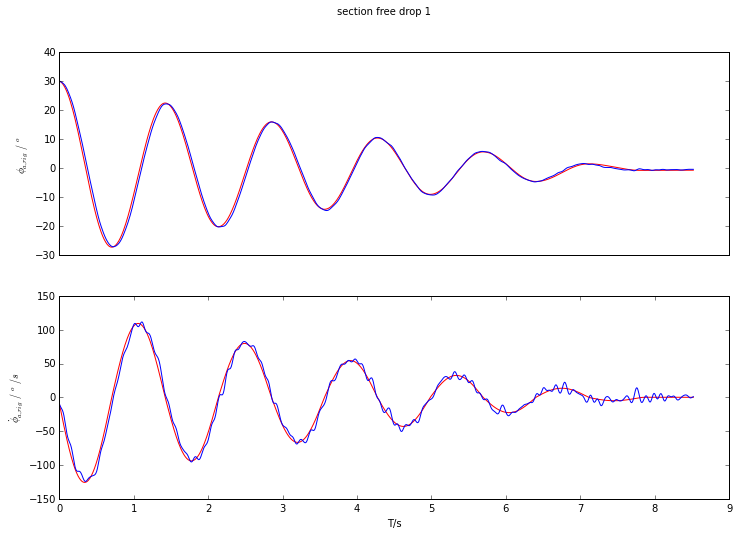

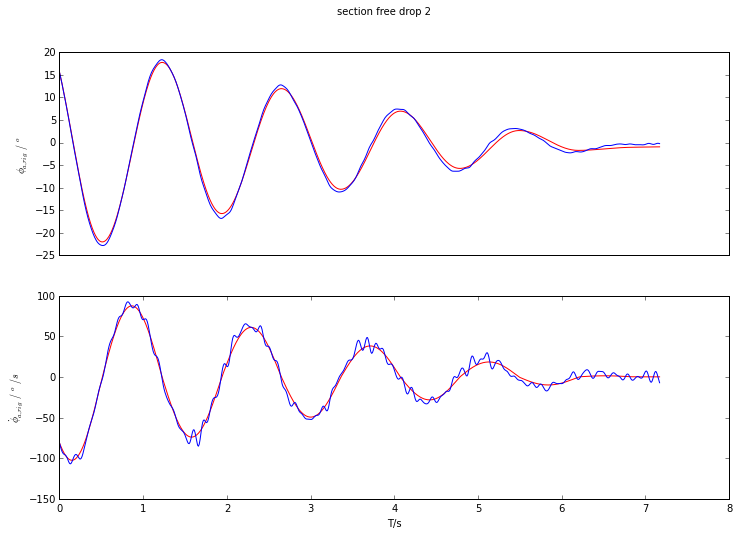

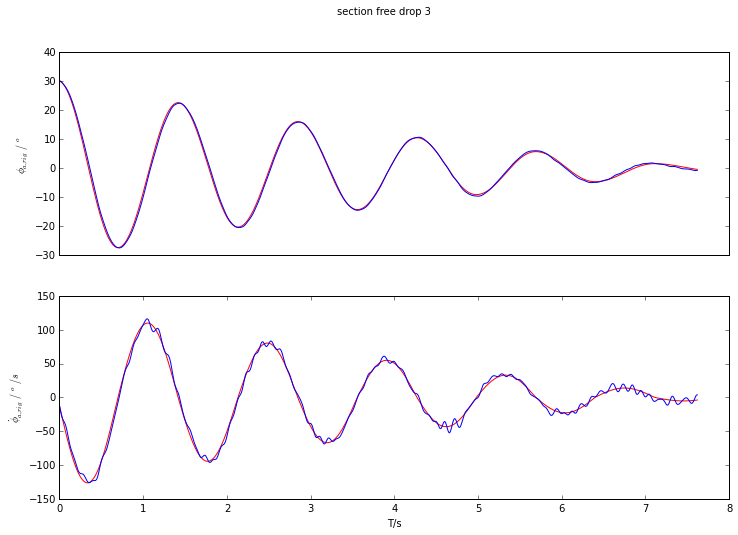

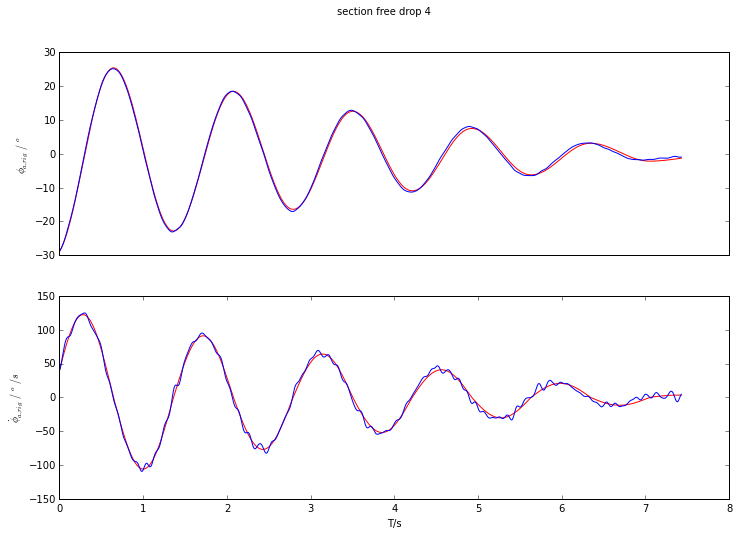

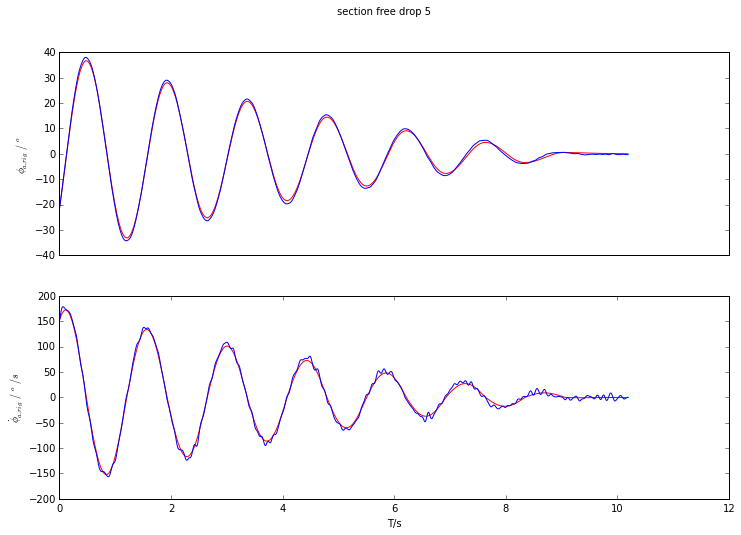

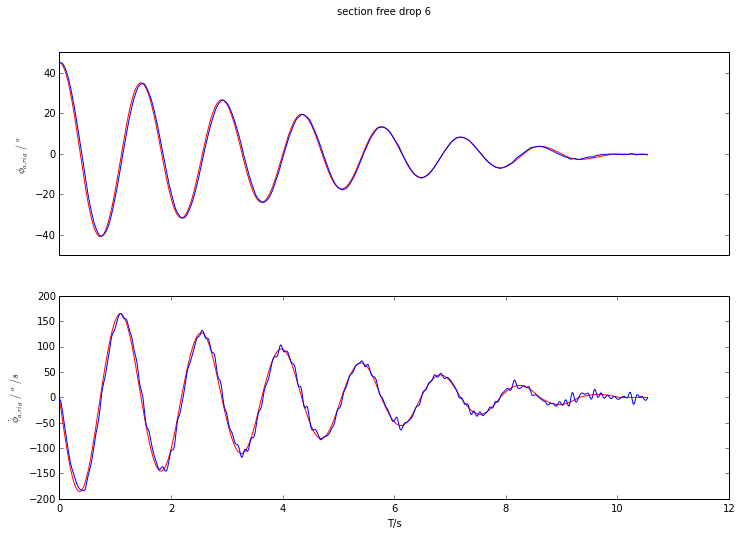

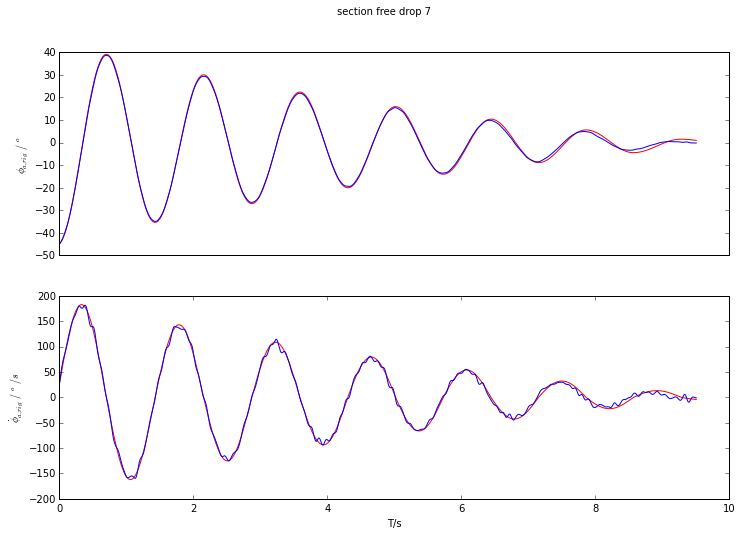

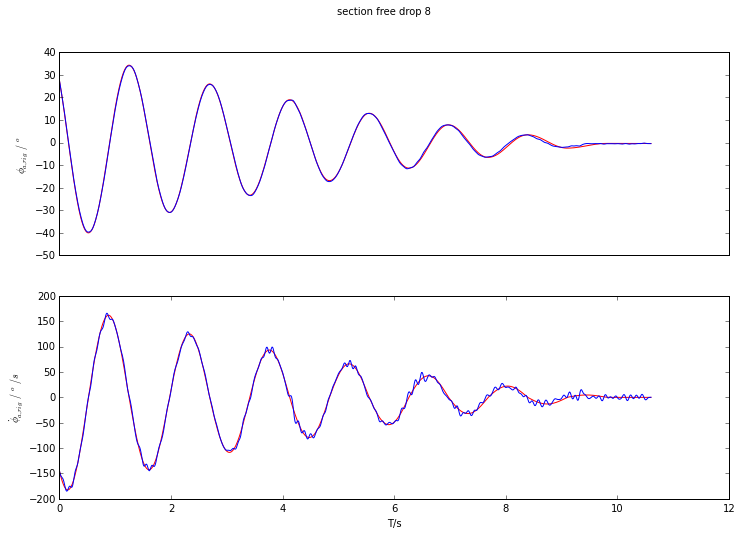

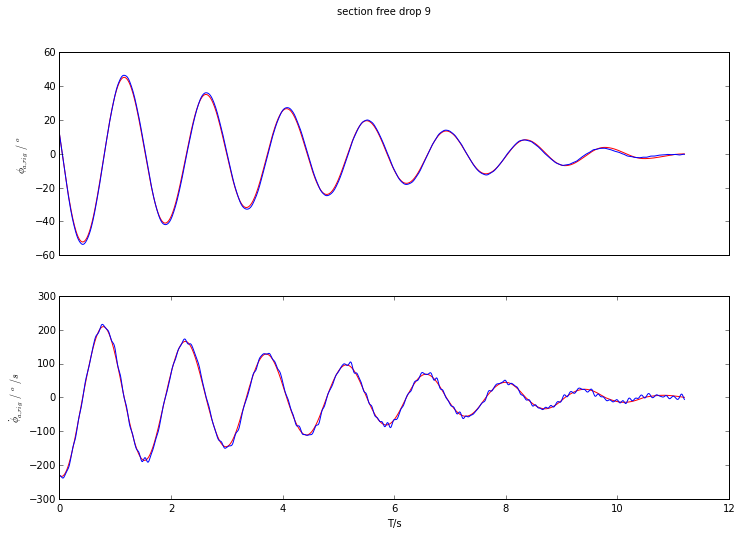

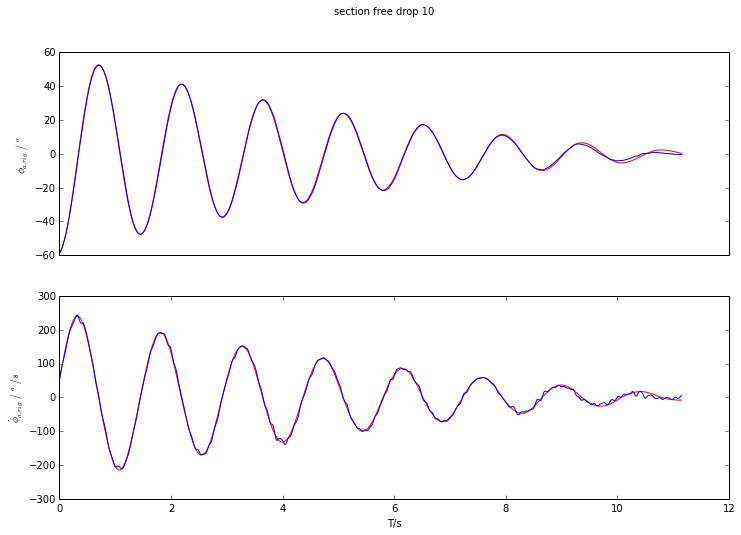

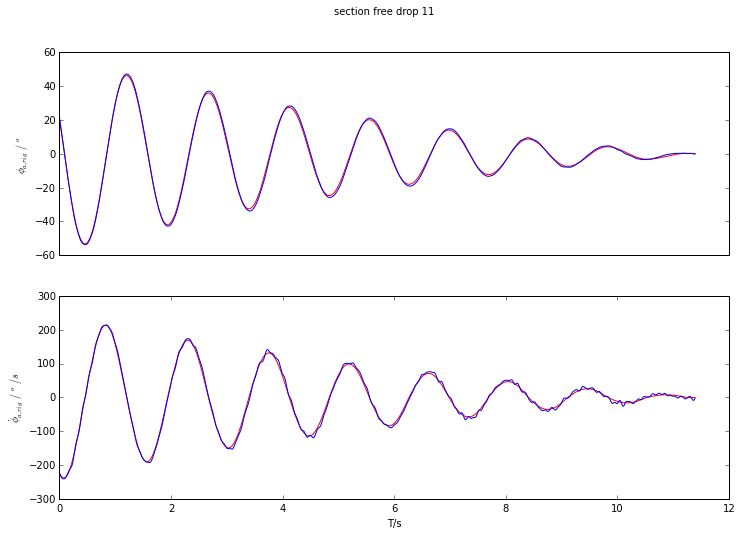

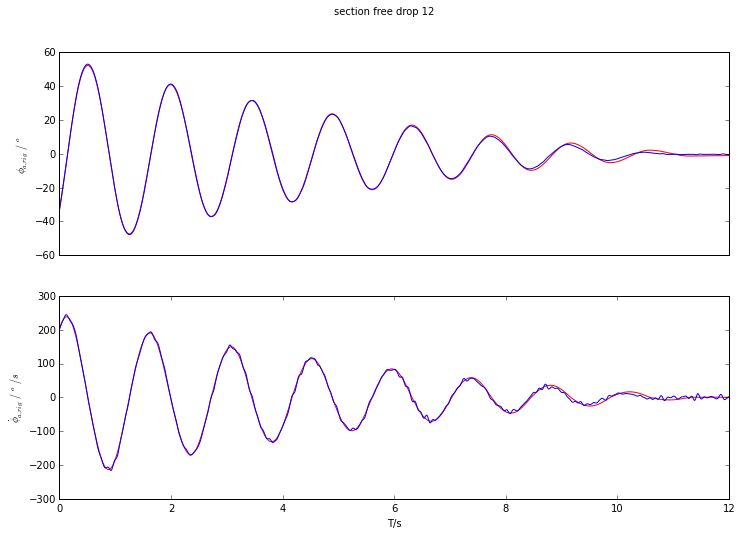

In [44]:
display_opt_params()

# show result
idx = range(len(time_marks))
display_data_for_test();

update_guess();

In [25]:
toggle_inputs()
button_qtconsole()